In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [446]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = 1000)

In [328]:
x_train.shape, x_test.shape

((8982,), (2246,))

In [329]:
length = np.array([len(x) for x in x_train])

In [330]:
# 길이 평균값과 중간값
print(np.mean(length), np.median(length), np.min(length), np.max(length))

145.5398574927633 95.0 13 2376


In [331]:
np.unique(y_train, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64),
 array([  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
         390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
          15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
          11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
          12,   18], dtype=int64))

- 로이터 뉴스 카테고리 분류 데이터
    - 총 11258개의 뉴스 기사 데이터
    - 46개의 카테고리 분류
    - 예)
        - 중부 지방은 대체로 맑겠으나, 남부 지방은 구름이 많겠습니다 -> 날씨
        - 올 초부터 유동성의 힘으로 주가가 일정하게 상승했습니다 -> 주식

# 복호화(?)

In [332]:
word_index = reuters.get_word_index()

In [333]:
idx2word = {0 : "<PAD>", 1: "<S>", 2 : "<UNK>"}

In [334]:
idx2word.update({value + 3 : key for key, value in word_index.items()})

# 숫자 단어 날리기

In [335]:
int_list = []
for i in list(word_index.keys()):
    try:
        j = int(i)
        
    except:
        j = "str"
    
    if type(j) == int:
        int_list.append(list(word_index.keys()).index(i))

# 무의미한 단어 제거해보기

In [336]:
whole_list = [j for i in x_train for j in i]

In [337]:
df = pd.DataFrame(whole_list)

In [338]:
df["count"] = 1

In [339]:
df_count = df.groupby(0).sum().sort_values(by = "count", ascending = False)

In [340]:
df_count["word"] = pd.Series(df_count.index).map(lambda x: idx2word[x])

In [389]:
df_count

,count,word
0,,
2,284013,of
4,65949,in
5,33791,said
6,32262,and
7,26309,a
...,...,...
996,158,consumption
953,157,owns
912,156,mining


In [440]:
remove_list = df_count[df_count["count"] >= len(x_train)*0.45]["word"].tolist()

In [411]:
remove_list.remove('<S>')

In [412]:
remove_list2 = [word_index[i] for i in remove_list]

In [441]:
remove_list

['of',
 'in',
 'said',
 'and',
 'a',
 'mln',
 '3',
 'for',
 'vs',
 'dlrs',
 'it',
 '<S>',
 'reuter',
 '000',
 'the',
 '1',
 'pct',
 'on',
 'from',
 'is',
 'that',
 'its',
 'cts',
 'by',
 'at',
 'year',
 'be',
 'with',
 '2',
 'will',
 'was',
 'billion',
 'he',
 'u',
 's',
 'net',
 'has',
 'would',
 'an',
 'as',
 'not',
 '5',
 '4',
 'loss']

In [442]:
x_train2 = []
for i in x_train:
    arr_removed = [j for j in i if j not in remove_list2 and j not in int_list]
    x_train2.append(arr_removed)

In [443]:
x_test2 = []
for i in x_test:
    arr_removed = [j for j in i if j not in remove_list2 and j not in int_list]
    x_test2.append(arr_removed)

In [444]:
length2 = np.array([len(x) for x in x_train2])

In [445]:
print(np.mean(length2), np.median(length2), np.min(length2), np.max(length2))

63.276441772433756 41.0 3 1410


# 데이터 분할 및 간단한 전처리

In [447]:
x_train2, x_val, y_train, y_val = train_test_split(x_train2, y_train, test_size = 0.2, random_state = 7)

In [448]:
# 관습적으로는 median 값보다 약간 크게 maxlen 설정하는 것이 좋음
train_seq = pad_sequences(x_train2, maxlen = 50, truncating = "post")
val_seq = pad_sequences(x_val, maxlen = 50, truncating = "post")
test_seq = pad_sequences(x_test2, maxlen = 50, truncating = "post")

In [449]:
y_oh_train = keras.utils.to_categorical(y_train)
y_oh_val = keras.utils.to_categorical(y_val)
y_oh_test = keras.utils.to_categorical(y_test)

# 모델 구성

In [456]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1000, 100, input_shape = (50,)))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(64, 5, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool1D(4))
model.add(keras.layers.LSTM(64, dropout = 0.3, return_sequences = True))
model.add(keras.layers.LSTM(64, dropout = 0.3))
model.add(keras.layers.Dense(46, activation = "softmax"))

In [457]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 50, 100)             │         100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 46, 64)              │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 46, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 11, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,358 (786.55 KB)

 Trainable params: 201,230 (786.05 KB)

 Non-trainable params: 128 (512.00 B)

In [458]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 3e-4)
adam = keras.optimizers.Adam(learning_rate = 3e-4)
model.compile(loss = "categorical_crossentropy", optimizer = rmsprop, metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights = True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/model-reuter-model.keras", save_best_only = True)

In [459]:
history = model.fit(train_seq, y_oh_train, batch_size = 32, epochs = 100,
                   validation_data = (val_seq, y_oh_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3591 - loss: 2.6967 - val_accuracy: 0.5632 - val_loss: 2.9602
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5501 - loss: 1.8088 - val_accuracy: 0.6060 - val_loss: 2.0032
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6111 - loss: 1.6143 - val_accuracy: 0.6299 - val_loss: 1.6488
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6400 - loss: 1.4917 - val_accuracy: 0.6578 - val_loss: 1.5020
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6644 - loss: 1.3971 - val_accuracy: 0.6784 - val_loss: 1.4384
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6873 - loss: 1.3110 - val_accuracy: 0.6939 - val_loss: 1.3992
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7014 - loss: 1.2334 - val_accuracy: 0.7028 - val_loss: 1.3209
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7126 - loss: 1.1622 - 

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8615 - loss: 0.5673 - val_accuracy: 0.7913 - val_loss: 0.9441
Epoch 51/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8719 - loss: 0.5454 - val_accuracy: 0.7874 - val_loss: 0.9331
Epoch 52/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8728 - loss: 0.5254 - val_accuracy: 0.7885 - val_loss: 0.9222
Epoch 53/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8590 - loss: 0.5501 - val_accuracy: 0.7858 - val_loss: 0.9327
Epoch 54/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8735 - loss: 0.5298 - val_accuracy: 0.7858 - val_loss: 0.9382
Epoch 55/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8704 - loss: 0.5389 - val_accuracy: 0.7908 - val_loss: 0.9196
Epoch 56/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8742 - loss: 0.5305 - val_accuracy: 0.7902 - val_loss: 0.9377
Epoch 57/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8717 - loss: 0.5198 - val_a

In [460]:
model.evaluate(test_seq, y_oh_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7904 - loss: 0.9336


[0.9559158682823181, 0.7836152911186218]

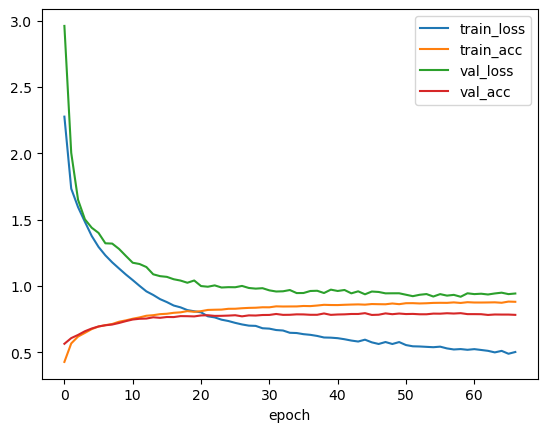

In [461]:
plt.figure()

plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["accuracy"], label = "acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend(("train_loss", "train_acc", "val_loss", "val_acc"))
plt.xlabel("epoch")
plt.show()

In [126]:
# 이성적인 현대인의 박제 버전
model.evaluate(test_seq, y_oh_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8136 - loss: 0.8399


[0.8693490624427795, 0.809884250164032]

In [798]:
# 최종박제 이거 왜 계속 갱신됨...? 원시인의 불 버전
model.evaluate(test_seq, y_oh_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8192 - loss: 0.8150


[0.8332313299179077, 0.8152270913124084]

In [55]:
# 강사님 취향
model = keras.Sequential()
model.add(keras.layers.Embedding(1000, 100, input_shape = (150,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(64, 5, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool1D(4))
model.add(keras.layers.LSTM(128, dropout = 0.5))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(46, activation = "softmax"))